# Predicting Customer Response to Telemarketing Campaigns

Nowadays, marketing spending in the banking industry is massive, meaning that it is essential for banks to optimize marketing strategies and improve effectiveness. Understanding customers’ need leads to more effective marketing plans, smarter product designs and greater customer satisfaction.

Main Objective: increase the effectiveness of the bank's telemarketing campaign
This project will enable the bank to develop a more granular understanding of its customer base, predict customers' response to its telemarketing campaign and establish a target customer profile for future marketing plans.

By analyzing customer features, such as demographics and transaction history, the bank will be able to predict customer saving behaviours and identify which type of customers is more likely to make term deposits. The bank can then focus its marketing efforts on those customers. This will not only allow the bank to secure deposits more effectively but also increase customer satisfaction by reducing undesirable advertisements for certain customers.

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection       import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics               import auc, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.svm          import SVC
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [4]:
data = pd.read_csv('bank-full.csv', delimiter=  ';')

In [5]:
data.head() 

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

## *Attribute Information:*

Input variables:

### *bank client data:*

1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
### *related with the last contact of the current campaign:*<br>
8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
### *other attributes:*
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
### *social and economic context attributes*
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

Output variable (desired target):<br>
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')<br>

In [6]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

## *Profile reporting:* 

In [7]:
ProfileReport(data)

There are 17 variables and 41188 records with no missing cells fortunately. 

#### Checking the data types: 

In [8]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

* y is the response variable which is our target variable and it is binary - yes or no. Which can be converted to binary. 
* 7 variables are numerical and 10 variables are categorical. 

In [9]:
# Conerting the target to binary 
data['y'] = data.y.map({'yes':1, 'no':0}) 

In [10]:
data.head() 

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  y  
0  unknown    5   may       261         1     -1         0  unknown  0  
1  unknown    5   may       151         1     -1         0  unknown  0  
2  unknown    5   may        76         1     -1         0  unknown  0  
3  unknown    5   may        92         1     -1         0  unknown  0  
4  unknown    5   may       198         1     -1         0  unknown  0

### *Univarite analysis of Categorical values:*

In [11]:
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 120)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True) * 100 
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(y= norm_count, x = norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 10)
    plt.xticks(rotation = 45)
    plt.ylabel('{}'.format(i), fontsize = 13)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

In [12]:
data.select_dtypes(include = 'object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

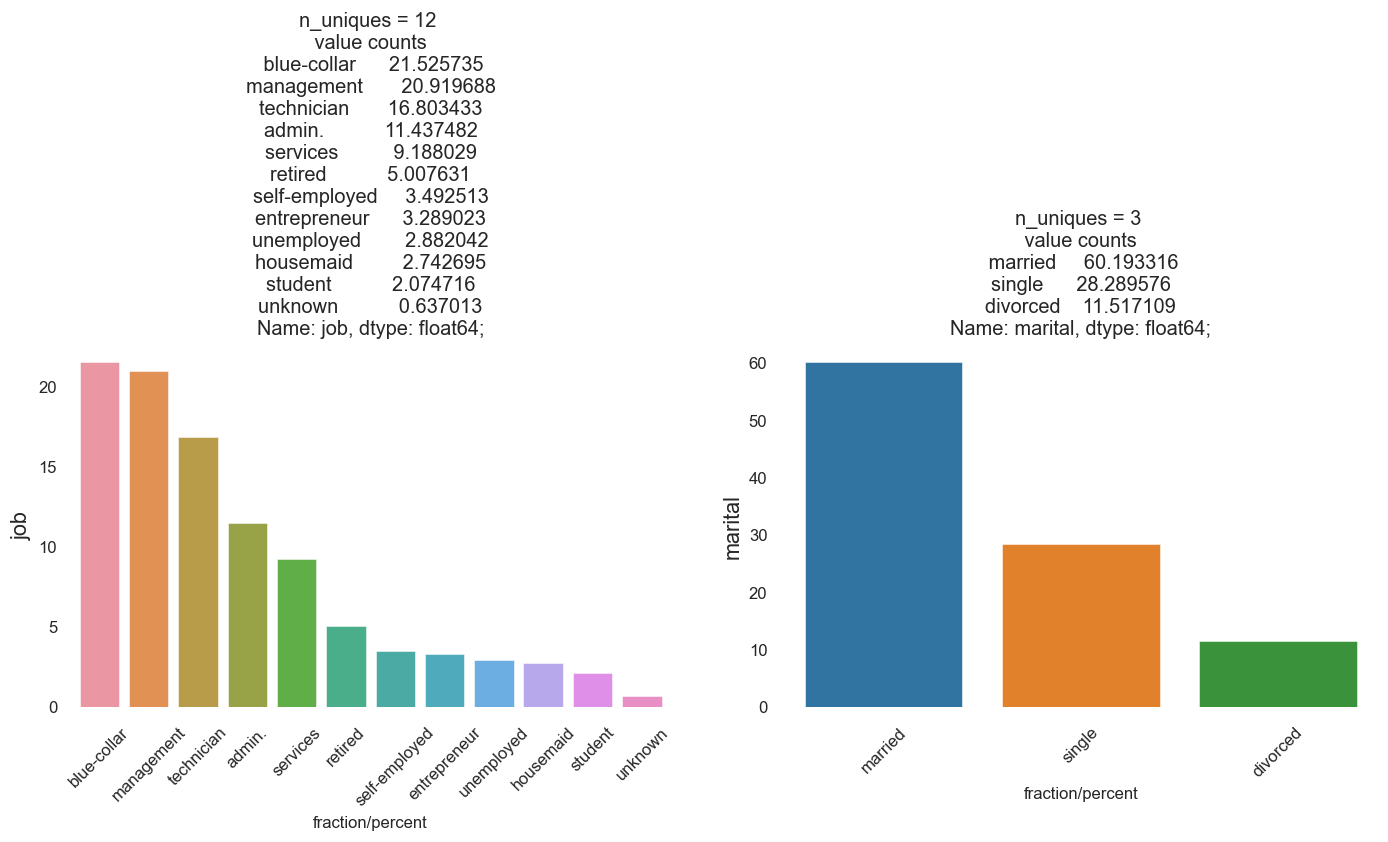

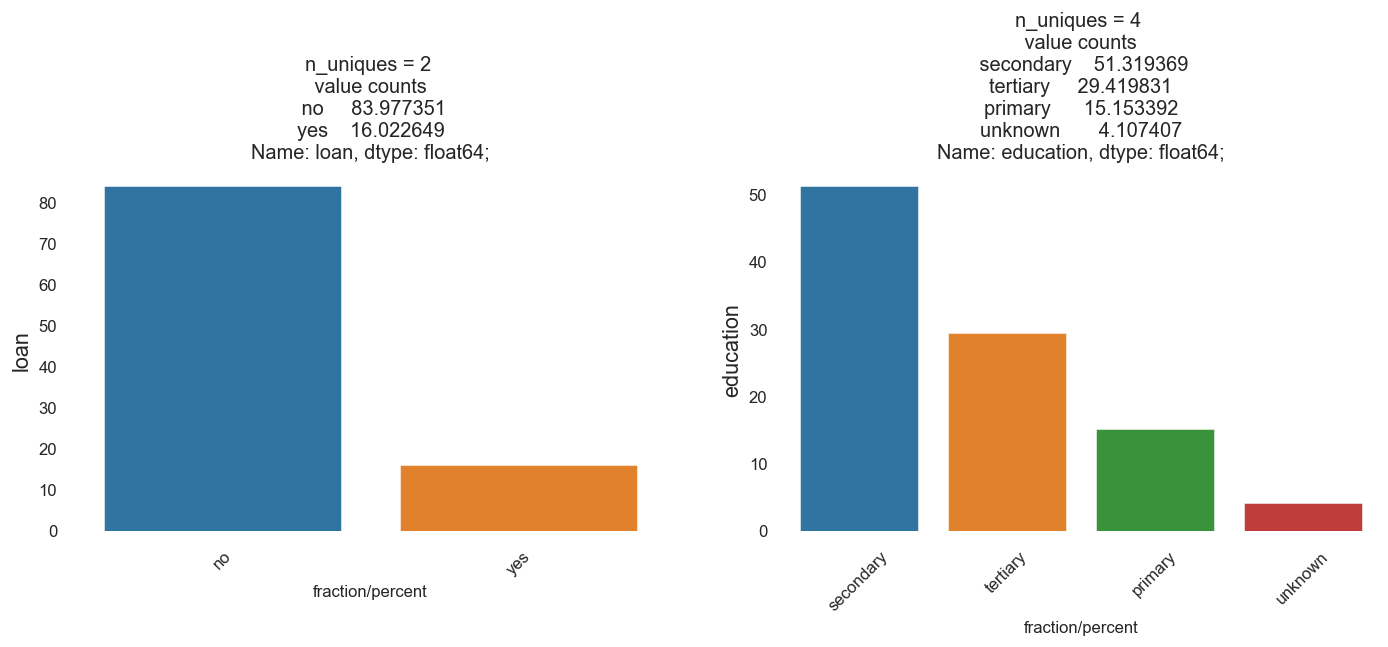

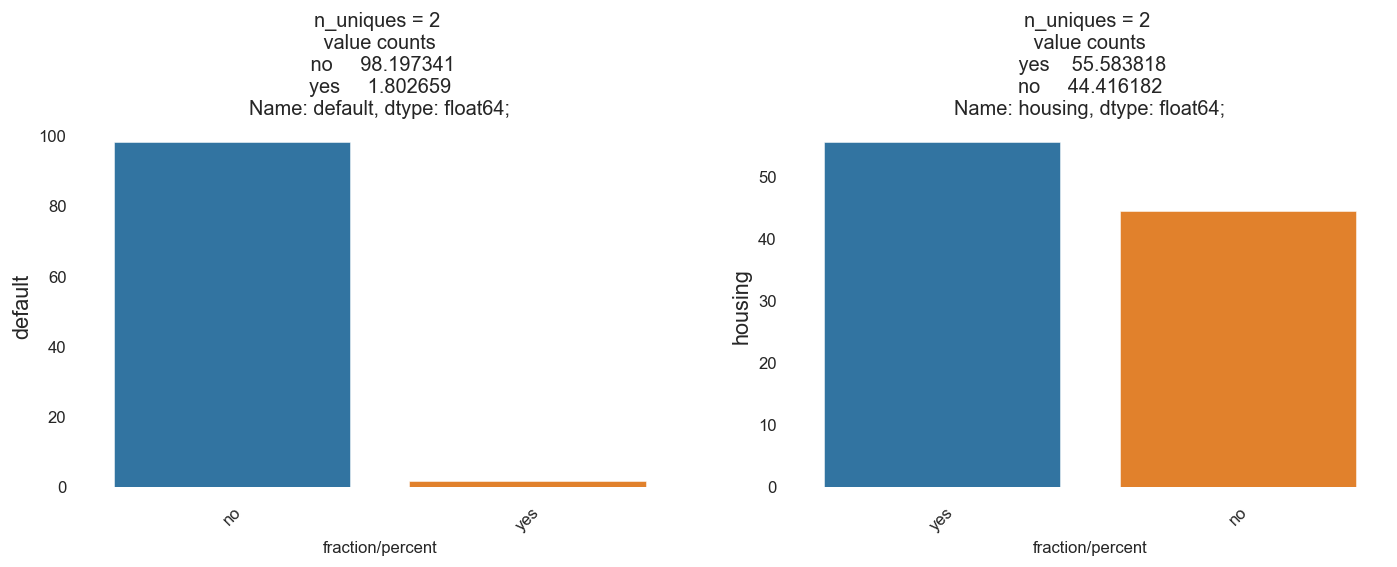

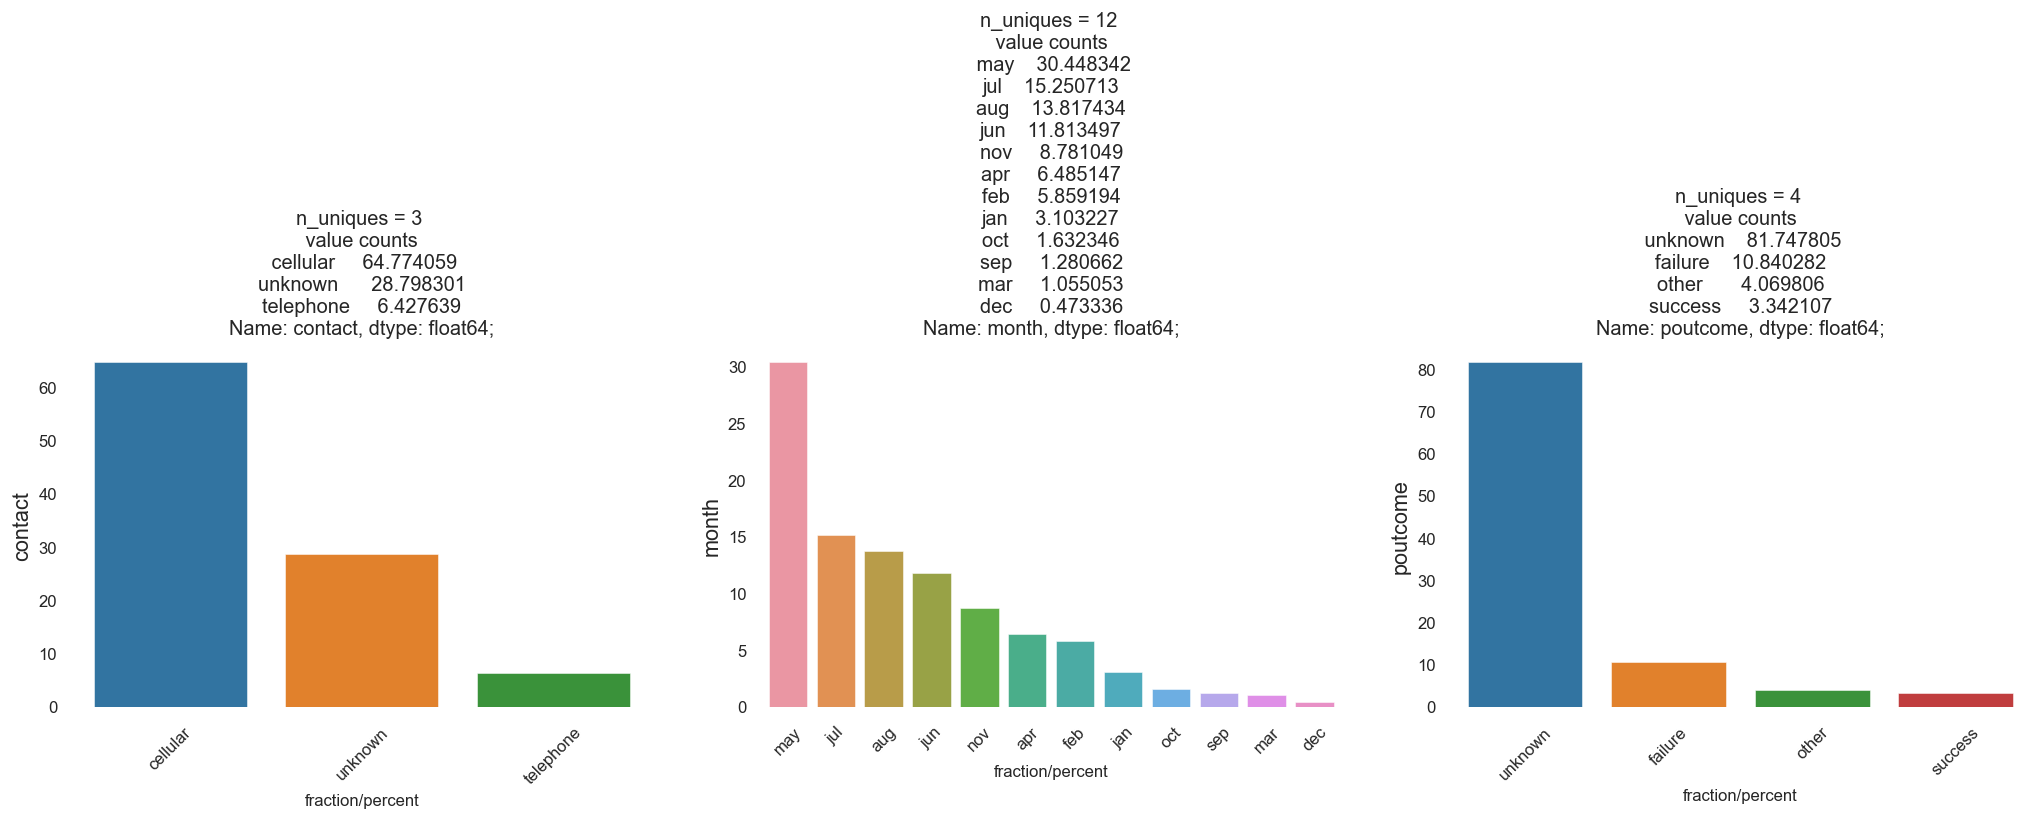

In [13]:
UVA_category(data, ['job','marital'] )

UVA_category(data, ['loan','education'] )

UVA_category(data, ['default', 'housing'] )

UVA_category(data, ['contact','month', 'poutcome'] )

Observations: 
- people in Blue-collared and management jobs are the most about 40% whereas maid, unemployed and students are the least. 
- Married customers are highest and divorced have been called the least. 
- about 83% of the records do not have a loan. 
- About 50% of the records have secondary education, 30% have tertiary. 4% were unknown which we have replaced with other. 
- About 55% has a housing loan. 
- 98% are not defaulters. 
- 63% were contacted through mobile and 6% through telephone. 
- 30% of the campaign calls were made in the month of may, followed with jul, aug and jun under 15%. oct, sep, march and dec had a small fractions of calls made. 
- 81% of the previous campaign were known and 10% was failure. Only 3% was success. 

There are values like 'unknown', 'others', which are useless like missing values. These values are removed. 

In [14]:
# Removing the columns in poutcome with others 

data.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [15]:
# Removing the records having poutcome as other since we it wont be useful

data = data[data['poutcome'] != 'other']

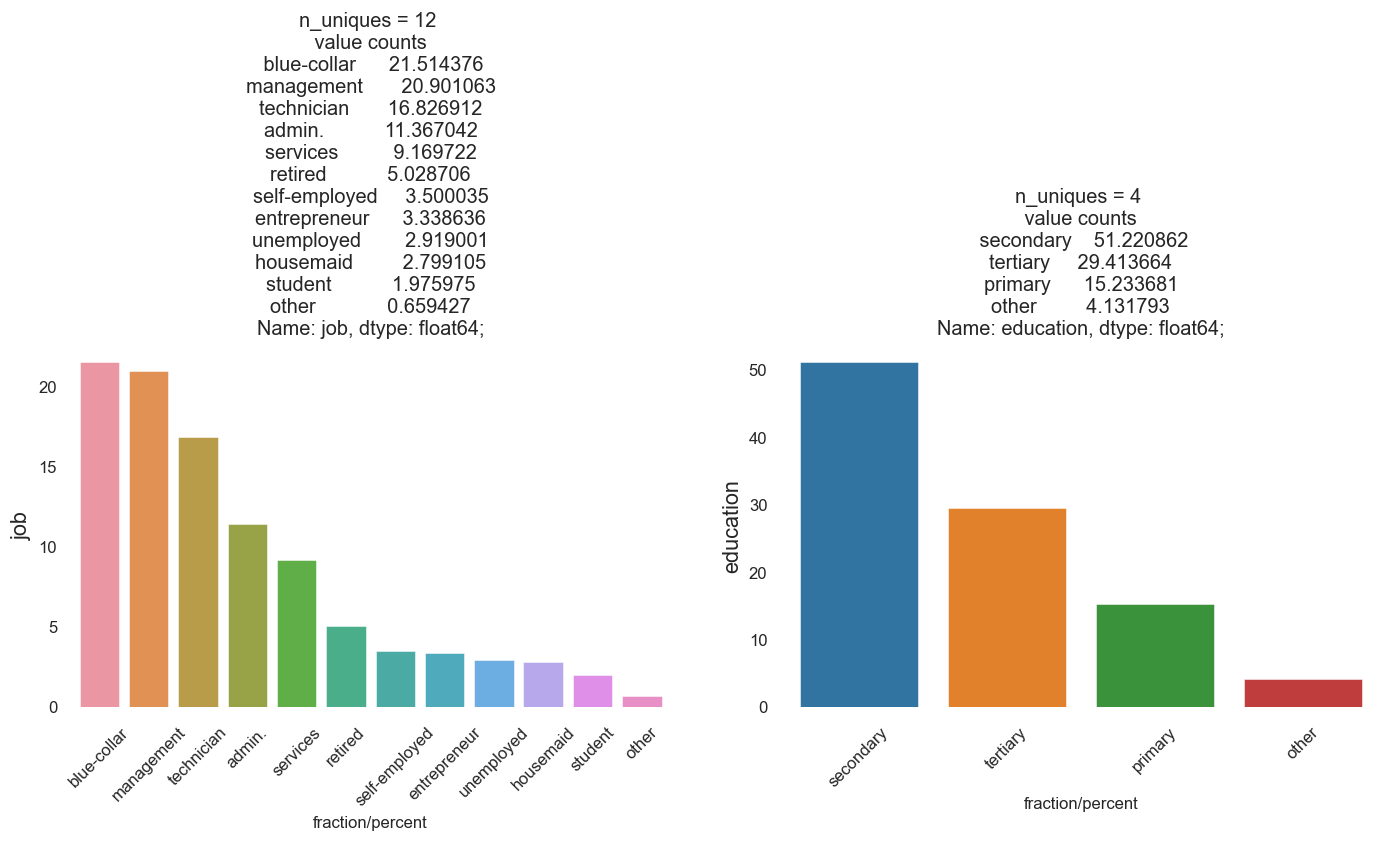

In [16]:
# Replacing 'unknown' values with 'others'

data[['job','education']] = data[['job','education']].replace(['unknown'], 'other')
UVA_category(data, ['job', 'education']) ;

## *Univariate analysis of the numerical variables:*

In [17]:
# custom function for easy and efficient analysis of numerical univariate

def UVA_numeric(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()
    std = data[i].std()
     

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; std = {}; range = {}\nmean = {}; median = {})'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2), round(std),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

In [18]:
data.select_dtypes(include = 'int64').columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y'],
      dtype='object')

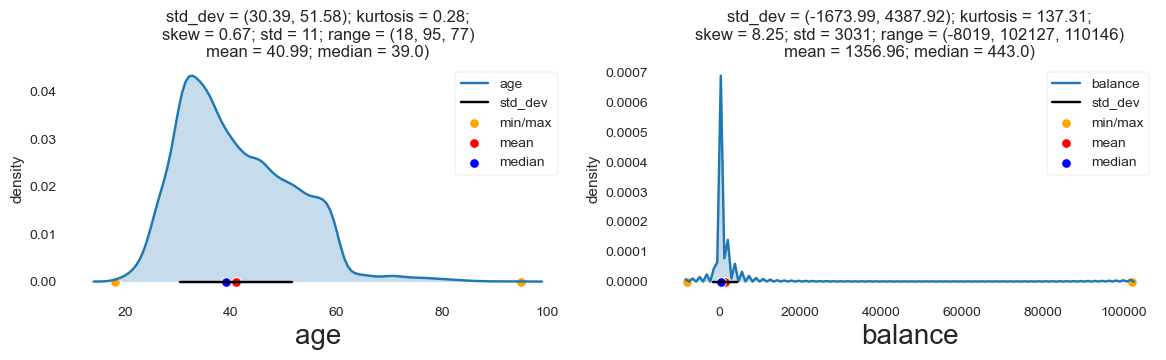

In [19]:
UVA_numeric(data, ['age','balance'])

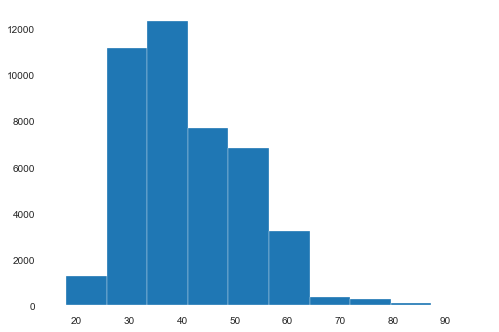

In [20]:
plt.hist(data['age'], bins = 10);

##### AGE: 
_> the age ranges from 18 to 95_ <br>

_> theres slight skewness. acceptable range 0.67_ <br>

_> Mean is slightly greater than the median indicating a left skewness, Kurtosis is slightly greater than 0 indicating a flatter tail. In the acceptable range -2 to +2_

*> std dev is lesser than the mean which denotes the data is spread around the mean.*

*> the distribution is fairly normal with small deviation. Majority of the customers are between 30 - 45.*

##### BALANCE: 
*> mean is higher than the median indicating a left skewness, with skewness value of 8.25 it is extremely left skewed.* 

*> Kurtosis is extremely high and it denotes heavy tails* 

*> std is greater than the meam which denotes that the data is not clustered around the mean.*
***

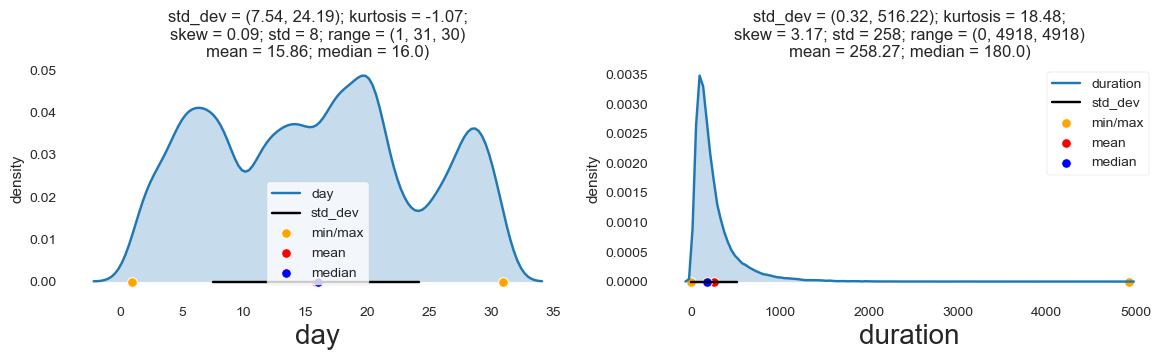

In [21]:
UVA_numeric(data, ['day', 'duration'])

##### DURATION: 
*> its highly left skewed and the average duration of a campain call is around 258 seconds, if the call duration is 0 then the response is 0. <br> > max duration is 4918 seconds thats about an hour and 20 mins. mostly an outlier, need to look into a boxplot <br> > std is less than mean which means the is clustered around the mean.*

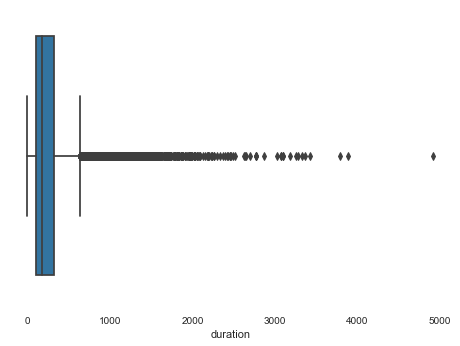

In [22]:
sns.boxplot(data['duration']);

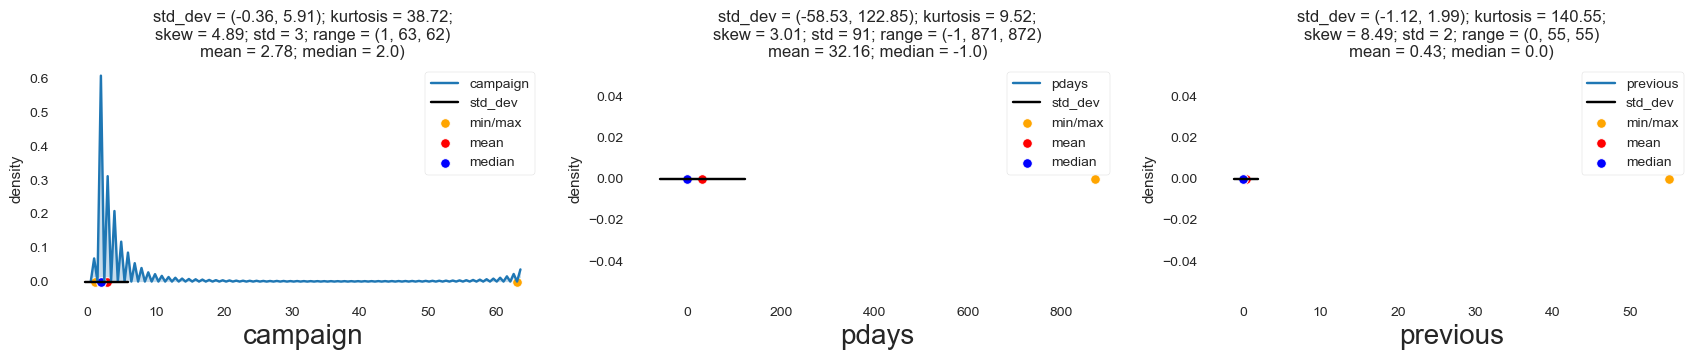

In [23]:
UVA_numeric(data, ['campaign', 'pdays', 'previous']);

### *Cleaning outliers*

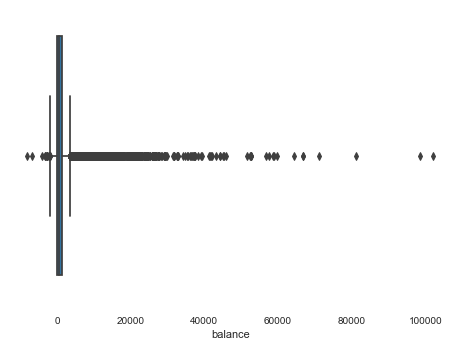

In [24]:
sns.boxplot(data['balance']);

In [25]:
df = data.copy()

In [26]:
df.head() 

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married      other      no     1506     yes   no   
4   33         other   single      other      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  y  
0  unknown    5   may       261         1     -1         0  unknown  0  
1  unknown    5   may       151         1     -1         0  unknown  0  
2  unknown    5   may        76         1     -1         0  unknown  0  
3  unknown    5   may        92         1     -1         0  unknown  0  
4  unknown    5   may       198         1     -1         0  unknown  0

In [27]:
from scipy.stats import zscore
df[['balance']].mean() 
df['balance_outliers'] = df['balance']
df['balance_outliers'] = zscore(df['balance_outliers'])

In [28]:
condition = (df['balance_outliers'] > 3 ) | (df['balance_outliers'] < -3)
df2 = df.drop(df[condition].index, axis = 0, inplace = False)

In [29]:
df2 = df2.drop('balance_outliers', 1)

In [30]:
df = df2.copy() 
df.head() 

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married      other      no     1506     yes   no   
4   33         other   single      other      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  y  
0  unknown    5   may       261         1     -1         0  unknown  0  
1  unknown    5   may       151         1     -1         0  unknown  0  
2  unknown    5   may        76         1     -1         0  unknown  0  
3  unknown    5   may        92         1     -1         0  unknown  0  
4  unknown    5   may       198         1     -1         0  unknown  0

In [31]:
df.rename(columns = {'y':'response'}, inplace = True)

In [32]:
df.response.value_counts() 

0    37785
1     4870
Name: response, dtype: int64

In [33]:
# Converting the seconds into mins of duration: 

df['duration'] = df['duration'].apply(lambda x: x/60).round(2)

In [34]:
# remove contact column :
df.drop('contact',1,inplace = True)

In [35]:
df.head() 

age           job  marital  education default  balance housing loan  day  \
0   58    management  married   tertiary      no     2143     yes   no    5   
1   44    technician   single  secondary      no       29     yes   no    5   
2   33  entrepreneur  married  secondary      no        2     yes  yes    5   
3   47   blue-collar  married      other      no     1506     yes   no    5   
4   33         other   single      other      no        1      no   no    5   

  month  duration  campaign  pdays  previous poutcome  response  
0   may      4.35         1     -1         0  unknown         0  
1   may      2.52         1     -1         0  unknown         0  
2   may      1.27         1     -1         0  unknown         0  
3   may      1.53         1     -1         0  unknown         0  
4   may      3.30         1     -1         0  unknown         0

In [36]:
# map months into numerical : 
df.month.unique() 

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [37]:
df.month = df.month.map({'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'jan':1, 'feb':2,
       'mar':3, 'apr':4, 'sep':9})

In [38]:
df.head() 

age           job  marital  education default  balance housing loan  day  \
0   58    management  married   tertiary      no     2143     yes   no    5   
1   44    technician   single  secondary      no       29     yes   no    5   
2   33  entrepreneur  married  secondary      no        2     yes  yes    5   
3   47   blue-collar  married      other      no     1506     yes   no    5   
4   33         other   single      other      no        1      no   no    5   

   month  duration  campaign  pdays  previous poutcome  response  
0      5      4.35         1     -1         0  unknown         0  
1      5      2.52         1     -1         0  unknown         0  
2      5      1.27         1     -1         0  unknown         0  
3      5      1.53         1     -1         0  unknown         0  
4      5      3.30         1     -1         0  unknown         0

In [39]:
# Removing 'other' education: 
df = df[df['education'] != 'other']

In [40]:
# Filtering out calls less than 5s. 
condition = (df.duration < 5/60)
df = df.drop(df[condition].index, axis = 0, inplace = False)

In [41]:
df.head() 

age           job  marital  education default  balance housing loan  day  \
0   58    management  married   tertiary      no     2143     yes   no    5   
1   44    technician   single  secondary      no       29     yes   no    5   
2   33  entrepreneur  married  secondary      no        2     yes  yes    5   
5   35    management  married   tertiary      no      231     yes   no    5   
6   28    management   single   tertiary      no      447     yes  yes    5   

   month  duration  campaign  pdays  previous poutcome  response  
0      5      4.35         1     -1         0  unknown         0  
1      5      2.52         1     -1         0  unknown         0  
2      5      1.27         1     -1         0  unknown         0  
5      5      2.32         1     -1         0  unknown         0  
6      5      3.62         1     -1         0  unknown         0

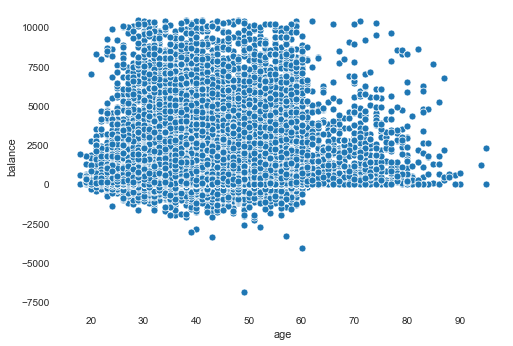

In [42]:
# Relationship between age and balance: 

sns.scatterplot(x = 'age', y = 'balance', data = df);

*no clear relationship between age and the balance; although customers above 60 have balance above 0 and below 5000 euros.* 

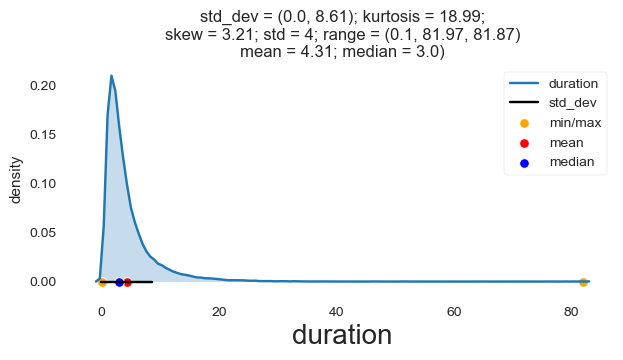

In [43]:
UVA_numeric(df, ['duration'])

In [44]:
df['duration'].quantile(0.25),df['duration'].quantile(0.75)

(1.73, 5.3)

*as we can see that the median of duration is 3 mins with IQR of 1.73 mins to 5.3mins.*

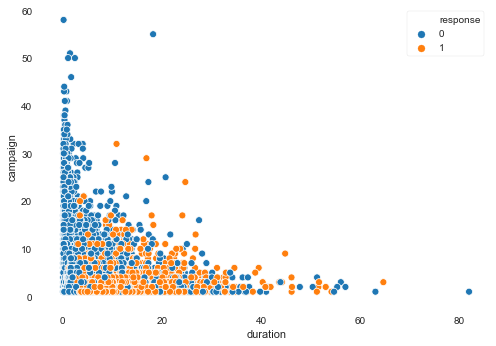

In [45]:
sns.scatterplot(x='duration',y='campaign', data = df, hue = 'response');

*as we can see that calls below 5 mins has no response. the bank should restrict calling the customer more than 5 times which has no positive effect in the campaign.*

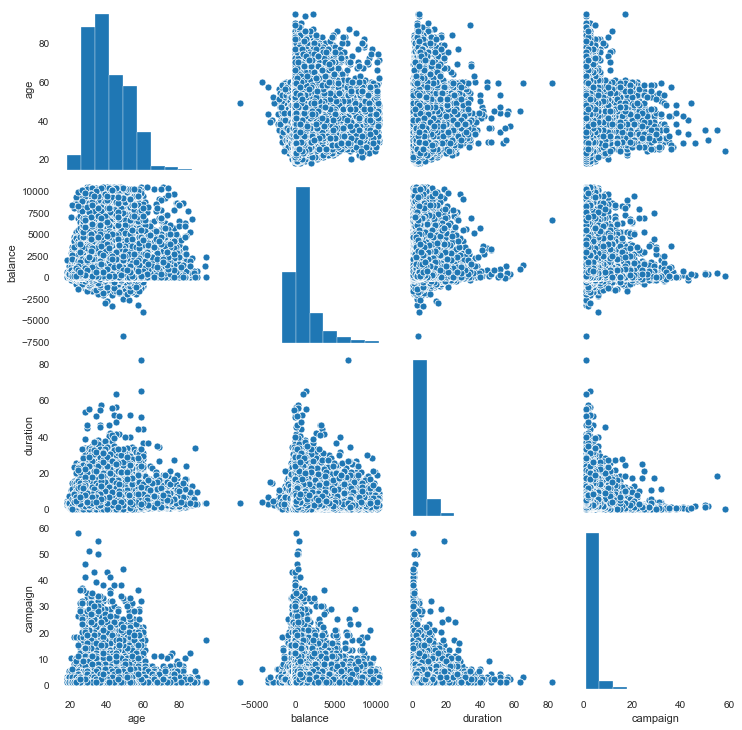

In [46]:
sns.pairplot(df[['age','balance','duration','campaign']]);
    

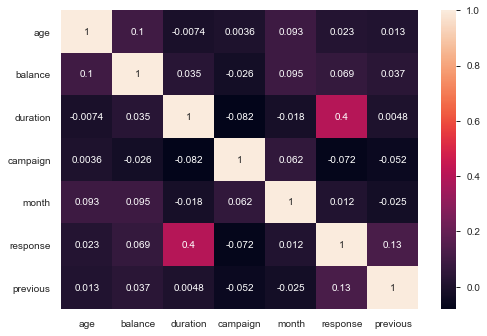

In [47]:
sns.heatmap(df[['age','balance','duration','campaign','month','response', 'previous']].corr(), annot = True );

*Campaign and duration has a correlation (negative), balance and age has good correlation.<br> duration and response are correlated positively. Previous and response have some correlation.* 

In [48]:
def agerange(col): 
    if col < 30: 
        return '<30'
    elif col >= 30 and col <= 39: 
        return '30-39'
    elif col >= 40 and col <=49: 
        return '40-49'
    elif col >=50 and col <= 59: 
        return '50-59'
    elif col > 60: 
        return '60+'
df['age_range'] = df.age.apply(agerange)

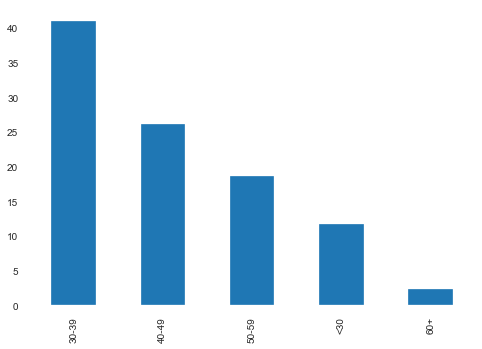

In [49]:
(df.age_range.value_counts(normalize = True) * 100).plot(kind = 'bar');

*as we can see that about 41% of the customers belong to age between 30 -39 and the least is 60+*

#### Lets see the subscription per age 

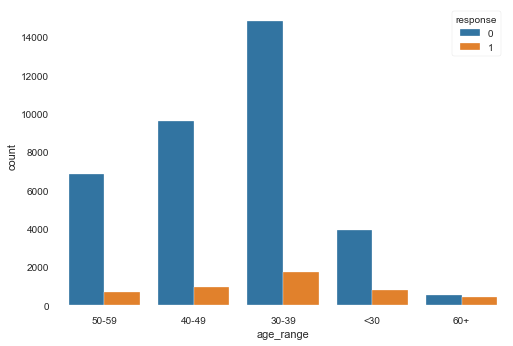

In [50]:
sns.countplot(x = df['age_range'], hue = df['response']);

In [51]:
def balance(col): 
    if col < 0: 
        return 'No balance'
    elif col > 0  and col <= 1000:
        return 'Low balance'
    elif col > 1000 and col <= 5000: 
        return 'average balance'
    elif col >5000: 
        return 'high balance'
df['balance_cat'] = df['balance'].apply(balance)

In [52]:
df.balance_cat.value_counts() 

Low balance        21398
average balance    10750
No balance          3504
high balance        1917
Name: balance_cat, dtype: int64

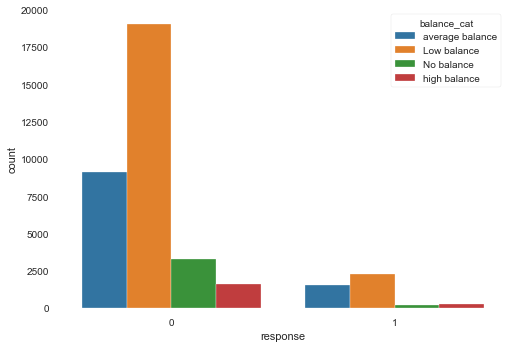

In [53]:
sns.countplot(x = df['response'], hue = df['balance_cat']);

In [54]:
df.head() 

age           job  marital  education default  balance housing loan  day  \
0   58    management  married   tertiary      no     2143     yes   no    5   
1   44    technician   single  secondary      no       29     yes   no    5   
2   33  entrepreneur  married  secondary      no        2     yes  yes    5   
5   35    management  married   tertiary      no      231     yes   no    5   
6   28    management   single   tertiary      no      447     yes  yes    5   

   month  duration  campaign  pdays  previous poutcome  response age_range  \
0      5      4.35         1     -1         0  unknown         0     50-59   
1      5      2.52         1     -1         0  unknown         0     40-49   
2      5      1.27         1     -1         0  unknown         0     30-39   
5      5      2.32         1     -1         0  unknown         0     30-39   
6      5      3.62         1     -1         0  unknown         0       <30   

       balance_cat  
0  average balance  
1      Low balance  
2      Low balance  
5      Low balance  
6      Low balance

In [55]:
df['poutcome'].value_counts()

unknown    34802
failure     4648
success     1391
Name: poutcome, dtype: int64

In [56]:
df['housing'] = df.housing.map({'yes':1, 'no':0})
df['loan'] = df.loan.map({'yes':1, 'no':0})
df['default'] = df.default.map({'yes':1, 'no':0})
df['education'] = df.education.map({'primary':1, 'secondary':2, 'tertiary':3})

In [57]:
df.head() 

age           job  marital  education  default  balance  housing  loan  \
0   58    management  married          3        0     2143        1     0   
1   44    technician   single          2        0       29        1     0   
2   33  entrepreneur  married          2        0        2        1     1   
5   35    management  married          3        0      231        1     0   
6   28    management   single          3        0      447        1     1   

   day  month  duration  campaign  pdays  previous poutcome  response  \
0    5      5      4.35         1     -1         0  unknown         0   
1    5      5      2.52         1     -1         0  unknown         0   
2    5      5      1.27         1     -1         0  unknown         0   
5    5      5      2.32         1     -1         0  unknown         0   
6    5      5      3.62         1     -1         0  unknown         0   

  age_range      balance_cat  
0     50-59  average balance  
1     40-49      Low balance  
2     30-39      Low balance  
5     30-39      Low balance  
6       <30      Low balance

## *Bivariate analysis:*

In [58]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

In [59]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import t as t_dist
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval

In [60]:
def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.mean()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data, color = 'grey')
  plt.title('categorical boxplot')
  

In [61]:
# df.response = df.response.astype('category')

### *Does higher age have higher campaign success?*

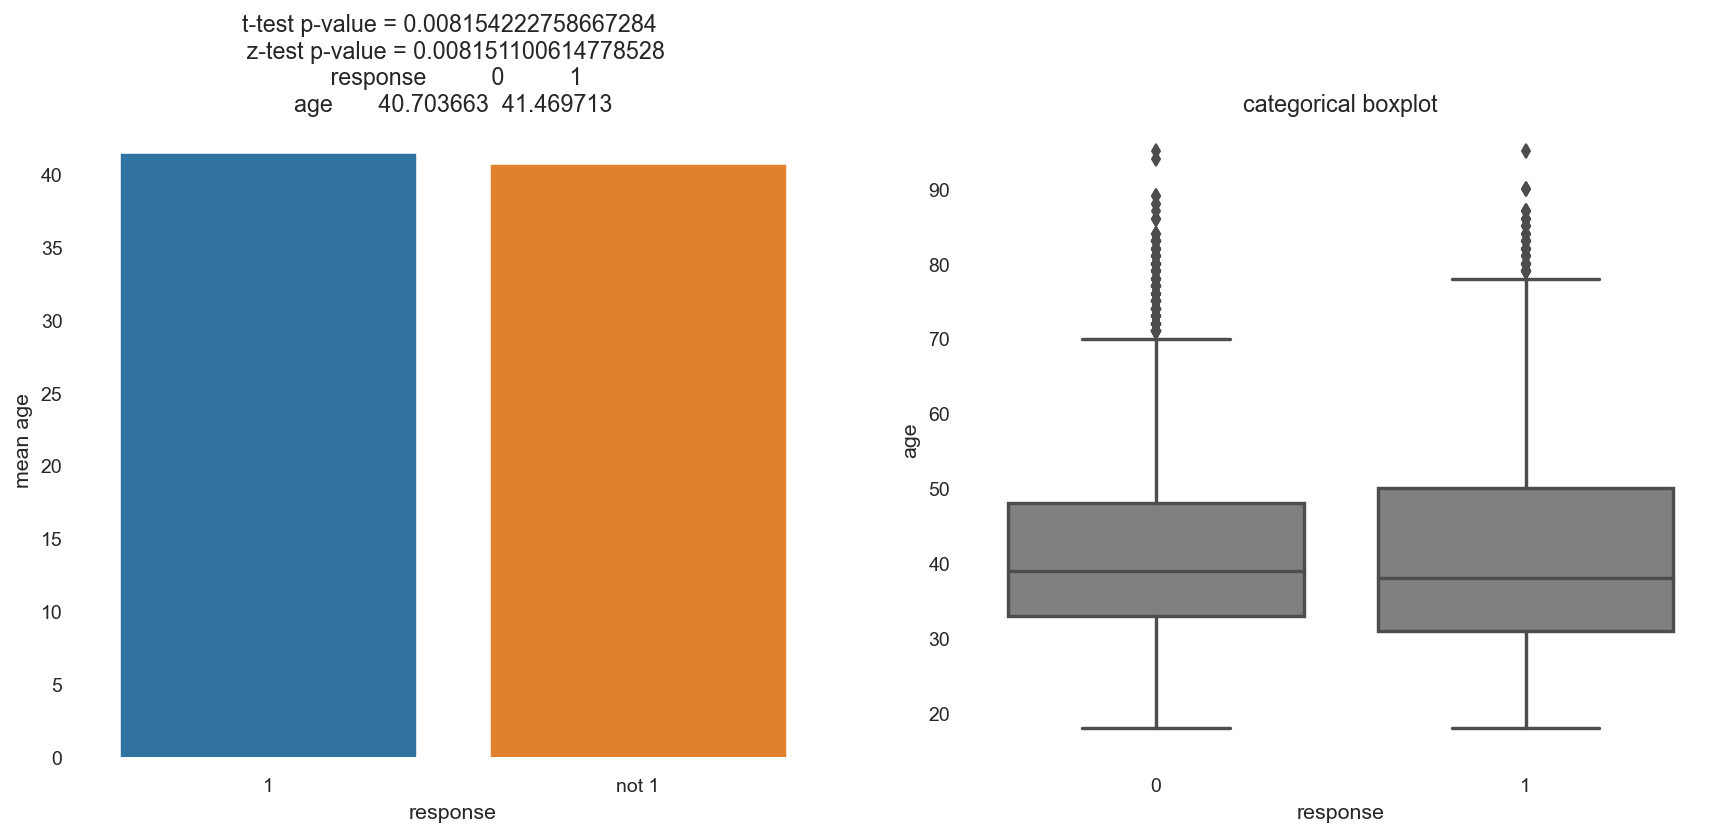

In [62]:
Bivariate_cont_cat(df, 'age','response',1)

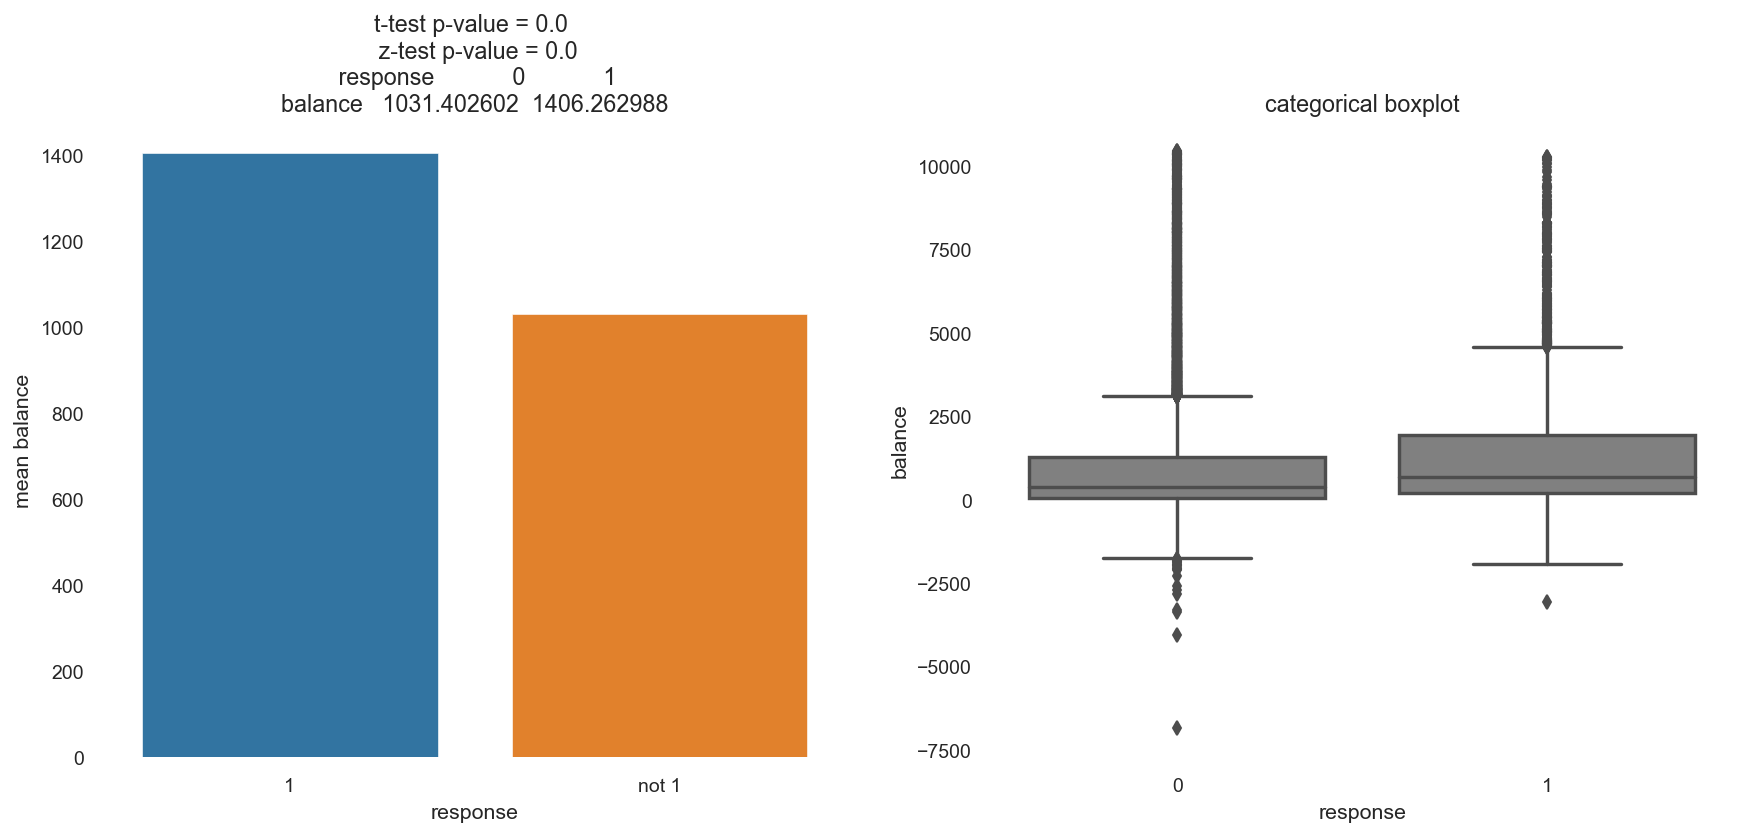

In [63]:
Bivariate_cont_cat(df, 'balance','response',1)

*people with higher balance tend to respond positive for the campaigns.* 

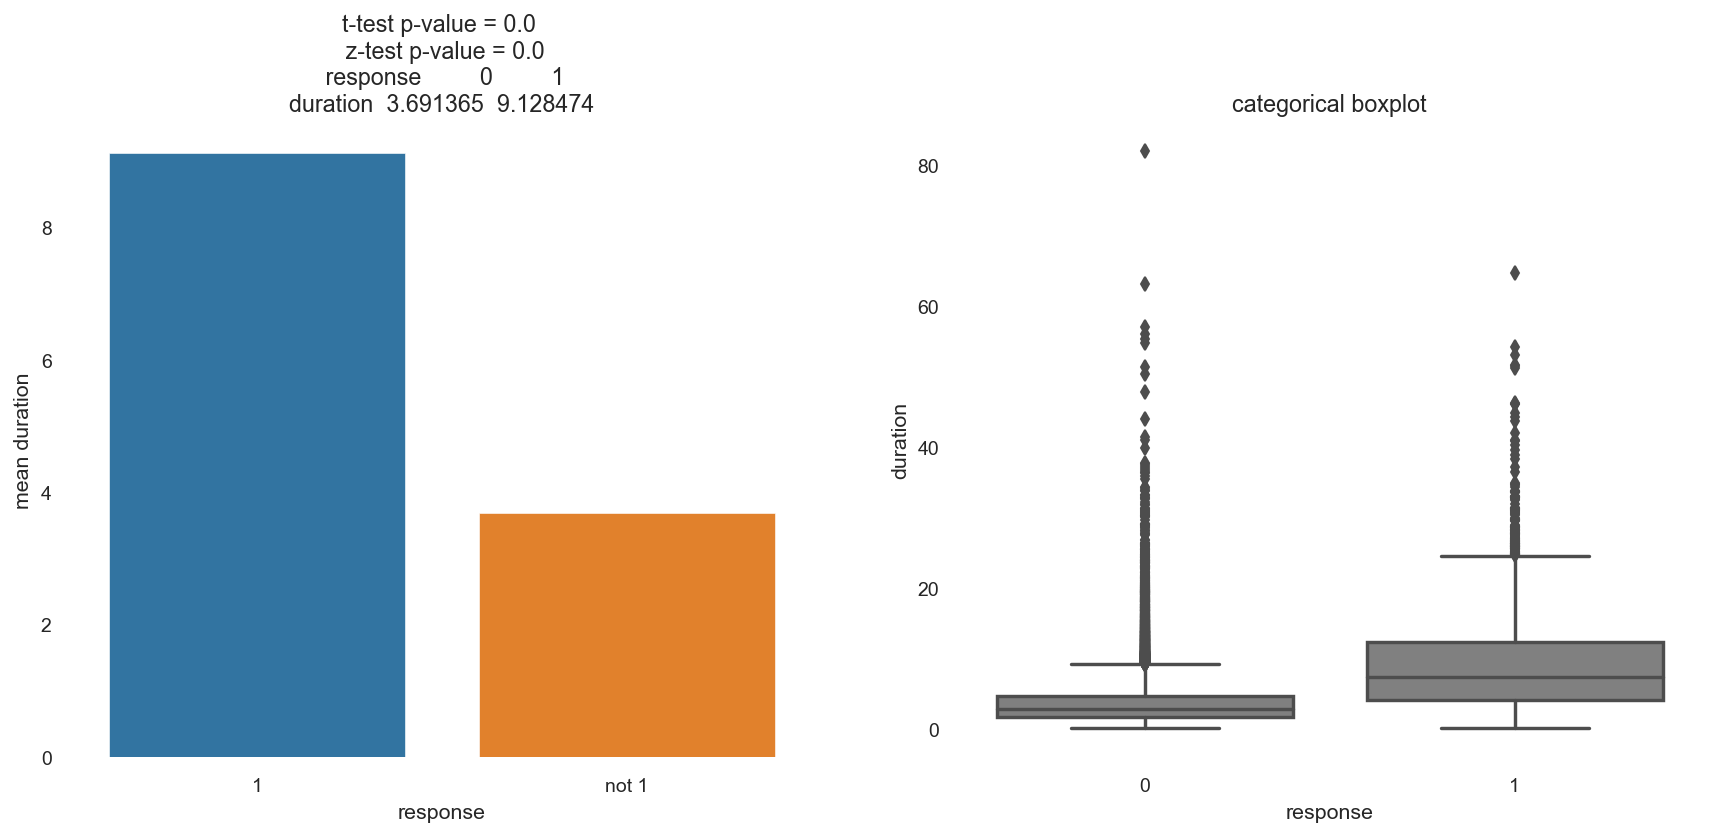

In [64]:
Bivariate_cont_cat(df, 'duration','response',1)

*customers who have been talking for higher duration tend to be a success reponse compared to the lesser duration* 
 


## *MODEL BUILDING :*

In [65]:

# Creating a KFold Cross Validation Function - AUC score 

def Evaluate_auc(Model_list, x, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    Auc       = []
    Name      = []

    for name,model in Model_list:

        roc_auc   = []
        accur     = []
        Name.append(name)

        for train, test in kf.split(x,y):
            xtrain, xtest = x.iloc[train,:],x.iloc[test,:]
            ytrain, ytest = y.iloc[train],y.iloc[test]

            model.fit(xtrain, ytrain)
            y_predict = model.predict(xtest)
            auc = roc_auc_score(ytest, y_predict)
            roc_auc.append(auc)

        Auc.append(np.mean(roc_auc))

    Report = pd.DataFrame({'AUC Score':Auc}, index=Name)
    return(Report.sort_values('AUC Score', ascending=False))

In [66]:
# Creating a KFold Cross Validation Function - f1score

def Evaluate_f(Model_list, x, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    f1       = []
    Name      = []

    for name,model in Model_list:

        f_score   = []
        accur     = []
        Name.append(name)

        for train, test in kf.split(x,y):
            xtrain, xtest = x.iloc[train,:],x.iloc[test,:]
            ytrain, ytest = y.iloc[train],y.iloc[test]

            model.fit(xtrain, ytrain)
            y_predict = model.predict(xtest)
            f = f1_score(ytest, y_predict)
            f_score.append(f)

        f1.append(np.mean(f_score))

    Report = pd.DataFrame({'f1 Score':f1}, index=Name)
    return(Report.sort_values('f1 Score', ascending=False))

In [67]:
lg  = LogisticRegression()
nb  = GaussianNB()
knn = KNeighborsClassifier()
dt  = DecisionTreeClassifier(random_state=0)
rf  = RandomForestClassifier(random_state=0)

Models = [['Logistic',lg],['Naive_Bayes',nb],['KNN',knn],['DecisionTree',dt],['RandomForest',rf]]
# Evaluate_f(Models, x, y)

In [68]:
df_dummies = pd.get_dummies(df)

In [69]:
df_dummies.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'month', 'duration', 'campaign', 'pdays', 'previous', 'response',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_other', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_success', 'poutcome_unknown',
       'age_range_30-39', 'age_range_40-49', 'age_range_50-59',
       'age_range_60+', 'age_range_<30', 'balance_cat_Low balance',
       'balance_cat_No balance', 'balance_cat_average balance',
       'balance_cat_high balance'],
      dtype='object')

In [70]:
df_dummies.head() 

age  education  default  balance  housing  loan  day  month  duration  \
0   58          3        0     2143        1     0    5      5      4.35   
1   44          2        0       29        1     0    5      5      2.52   
2   33          2        0        2        1     1    5      5      1.27   
5   35          3        0      231        1     0    5      5      2.32   
6   28          3        0      447        1     1    5      5      3.62   

   campaign  ...  poutcome_unknown  age_range_30-39  age_range_40-49  \
0         1  ...                 1                0                0   
1         1  ...                 1                0                1   
2         1  ...                 1                1                0   
5         1  ...                 1                1                0   
6         1  ...                 1                0                0   

   age_range_50-59  age_range_60+  age_range_<30  balance_cat_Low balance  \
0                1              0              0                        0   
1                0              0              0                        1   
2                0              0              0                        1   
5                0              0              0                        1   
6                0              0              1                        1   

   balance_cat_No balance  balance_cat_average balance  \
0                       0                            1   
1                       0                            0   
2                       0                            0   
5                       0                            0   
6                       0                            0   

   balance_cat_high balance  
0                         0  
1                         0  
2                         0  
5                         0  
6                         0  

[5 rows x 40 columns]

In [71]:
x = df_dummies.drop('response',1)
y = df_dummies.response

In [72]:
x.head(2) 

age  education  default  balance  housing  loan  day  month  duration  \
0   58          3        0     2143        1     0    5      5      4.35   
1   44          2        0       29        1     0    5      5      2.52   

   campaign  ...  poutcome_unknown  age_range_30-39  age_range_40-49  \
0         1  ...                 1                0                0   
1         1  ...                 1                0                1   

   age_range_50-59  age_range_60+  age_range_<30  balance_cat_Low balance  \
0                1              0              0                        0   
1                0              0              0                        1   

   balance_cat_No balance  balance_cat_average balance  \
0                       0                            1   
1                       0                            0   

   balance_cat_high balance  
0                         0  
1                         0  

[2 rows x 39 columns]

In [73]:
y.head(2)

0    0
1    0
Name: response, dtype: int64

In [74]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,random_state = 56, test_size = 0.35)

In [75]:
xtrain.shape, xtest.shape

((26546, 39), (14295, 39))

In [76]:
ytrain.shape, ytest.shape

((26546,), (14295,))

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
log = LogisticRegression() 

log.fit(xtrain,ytrain)

LogisticRegression()

In [78]:
# F1 score
Evaluate_f(Models, x, y)

f1 Score
DecisionTree  0.477844
RandomForest  0.461446
Naive_Bayes   0.425880
Logistic      0.313761
KNN           0.249303

In [79]:
# AUC ROC score
Evaluate_auc(Models, x, y)

AUC Score
DecisionTree   0.708330
Naive_Bayes    0.694450
RandomForest   0.666133
Logistic       0.597849
KNN            0.572452

## *Lets perform scaling to see if the model performances increase*

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
x_scaled = scaler.fit_transform(x)

In [81]:
x_scaled = pd.DataFrame(x_scaled, columns = x.columns)
x_scaled.head() 

age  education  default   balance  housing  loan       day     month  \
0  0.519481        1.0      0.0  0.519954      1.0   0.0  0.133333  0.363636   
1  0.337662        0.5      0.0  0.397687      1.0   0.0  0.133333  0.363636   
2  0.194805        0.5      0.0  0.396125      1.0   1.0  0.133333  0.363636   
3  0.220779        1.0      0.0  0.409370      1.0   0.0  0.133333  0.363636   
4  0.129870        1.0      0.0  0.421862      1.0   1.0  0.133333  0.363636   

   duration  campaign  ...  poutcome_unknown  age_range_30-39  \
0  0.051912       0.0  ...               1.0              0.0   
1  0.029559       0.0  ...               1.0              0.0   
2  0.014291       0.0  ...               1.0              1.0   
3  0.027116       0.0  ...               1.0              1.0   
4  0.042995       0.0  ...               1.0              0.0   

   age_range_40-49  age_range_50-59  age_range_60+  age_range_<30  \
0              0.0              1.0            0.0            0.0   
1              1.0              0.0            0.0            0.0   
2              0.0              0.0            0.0            0.0   
3              0.0              0.0            0.0            0.0   
4              0.0              0.0            0.0            1.0   

   balance_cat_Low balance  balance_cat_No balance  \
0                      0.0                     0.0   
1                      1.0                     0.0   
2                      1.0                     0.0   
3                      1.0                     0.0   
4                      1.0                     0.0   

   balance_cat_average balance  balance_cat_high balance  
0                          1.0                       0.0  
1                          0.0                       0.0  
2                          0.0                       0.0  
3                          0.0                       0.0  
4                          0.0                       0.0  

[5 rows x 39 columns]

In [82]:
# F1 score
Evaluate_f(Models, x_scaled, y)

f1 Score
DecisionTree  0.477841
RandomForest  0.462411
Naive_Bayes   0.417705
Logistic      0.413160
KNN           0.302817

Theres 10% improvement in Logistic regression

In [83]:
# AUC ROC score 
Evaluate_auc(Models, x_scaled, y)

AUC Score
DecisionTree   0.708460
Naive_Bayes    0.691795
RandomForest   0.666661
Logistic       0.640941
KNN            0.593627

## *Lets perform smote to balance our dataset*

In [84]:
!pip install imblearn

In [85]:
!pip install SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE()

In [86]:
X_smote, Y_smote = smt.fit_sample(x_scaled,y)

In [87]:
x_scaled_smoted = pd.DataFrame(X_smote, columns=x_scaled.columns)

y = pd.DataFrame(Y_smote, columns=['response'])

In [88]:
# F1 score
Evaluate_f(Models, x_scaled_smoted, y)

f1 Score
RandomForest  0.950968
DecisionTree  0.913676
KNN           0.886289
Logistic      0.838543
Naive_Bayes   0.703655

#### *Theres 40% improvement in Logistic regression from previous iteration.* 

In [89]:
# AUC ROC score 
Evaluate_auc(Models, x_scaled_smoted, y)

AUC Score
RandomForest   0.950224
DecisionTree   0.913232
KNN            0.878674
Logistic       0.840525
Naive_Bayes    0.726324

In [90]:
x_scaled.shape

(40841, 39)

## *Lets try selecting the best variables using kbest*

In [91]:
from sklearn.feature_selection     import SelectKBest, chi2
select = SelectKBest(k=30)
x_best = pd.DataFrame(select.fit_transform(x_scaled_smoted, y), columns=x_scaled_smoted.columns[select.get_support()])

In [92]:
x_best.head() 

age  education  default   balance  housing  loan       day  duration  \
0  0.519481        1.0      0.0  0.519954      1.0   0.0  0.133333  0.051912   
1  0.337662        0.5      0.0  0.397687      1.0   0.0  0.133333  0.029559   
2  0.194805        0.5      0.0  0.396125      1.0   1.0  0.133333  0.014291   
3  0.220779        1.0      0.0  0.409370      1.0   0.0  0.133333  0.027116   
4  0.129870        1.0      0.0  0.421862      1.0   1.0  0.133333  0.042995   

   campaign  pdays  ...  poutcome_success  poutcome_unknown  age_range_30-39  \
0       0.0    0.0  ...               0.0               1.0              0.0   
1       0.0    0.0  ...               0.0               1.0              0.0   
2       0.0    0.0  ...               0.0               1.0              1.0   
3       0.0    0.0  ...               0.0               1.0              1.0   
4       0.0    0.0  ...               0.0               1.0              0.0   

   age_range_40-49  age_range_50-59  age_range_60+  age_range_<30  \
0              0.0              1.0            0.0            0.0   
1              1.0              0.0            0.0            0.0   
2              0.0              0.0            0.0            0.0   
3              0.0              0.0            0.0            0.0   
4              0.0              0.0            0.0            1.0   

   balance_cat_Low balance  balance_cat_No balance  \
0                      0.0                     0.0   
1                      1.0                     0.0   
2                      1.0                     0.0   
3                      1.0                     0.0   
4                      1.0                     0.0   

   balance_cat_average balance  
0                          1.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  

[5 rows x 30 columns]

In [93]:
x_best.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_services', 'job_student', 'marital_married', 'marital_single',
       'poutcome_success', 'poutcome_unknown', 'age_range_30-39',
       'age_range_40-49', 'age_range_50-59', 'age_range_60+', 'age_range_<30',
       'balance_cat_Low balance', 'balance_cat_No balance',
       'balance_cat_average balance'],
      dtype='object')

In [94]:
# F1 score
Evaluate_f(Models, x_best, y)

f1 Score
RandomForest  0.937594
DecisionTree  0.888724
KNN           0.876762
Logistic      0.837509
Naive_Bayes   0.702078

#### *Theres No increase after kbest* 

In [95]:
# AUC ROC score 
Evaluate_auc(Models, x_best, y)

AUC Score
RandomForest   0.936581
DecisionTree   0.887983
KNN            0.870413
Logistic       0.839669
Naive_Bayes    0.731600

In [96]:
# Creating a Grid Search function 

def Grid(model, par, x, y):
    GS = GridSearchCV(model, par, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_

In [97]:
grid_tree = dt  = DecisionTreeClassifier(random_state=0)
tree_parameter  = {'criterion':['gini','entropy'],'max_depth':np.arange(1,30)}
Grid(grid_tree, tree_parameter, x_scaled_smoted, y)

{'criterion': 'gini', 'max_depth': 4}

In [98]:
grid_rf = RandomForestClassifier(random_state=0)
rf_parameter  = {'criterion':['gini','entropy'],'max_depth':np.arange(1,20)}
Grid(grid_rf, rf_parameter, x_scaled_smoted, y)

{'criterion': 'gini', 'max_depth': 19}

In [99]:
grid_knn = KNeighborsClassifier()
knn_parameter  = {'weights':['uniform','distance'],'metric':['minkowski','euclidean']}
Grid(grid_knn, knn_parameter, x_scaled_smoted, y)

{'metric': 'minkowski', 'weights': 'distance'}

In [100]:
tuned_tree = DecisionTreeClassifier(random_state=0, criterion = 'entropy',max_depth = 11) 
tuned_forest = RandomForestClassifier(random_state=0, criterion = 'gini', max_depth = 19 )
tuned_knn = KNeighborsClassifier(weights = 'distance', metric = 'minkowski')
Models = [['tuned_KNN',tuned_knn],['DecisionTree_tuned',tuned_tree],['RandomForest_tuned',tuned_forest]]
Evaluate_auc(Models, x_scaled_smoted, y)

AUC Score
RandomForest_tuned   0.940366
tuned_KNN            0.901064
DecisionTree_tuned   0.899160

## *Ensembling*

In [101]:
bag_dt     = BaggingClassifier(base_estimator=dt ,random_state=0)
boost_dt   = AdaBoostClassifier(base_estimator=dt ,random_state=0)

boost_knn  = BaggingClassifier(base_estimator=knn ,random_state=0)

boost_rf   = AdaBoostClassifier(base_estimator=rf, n_estimators=50 ,random_state=0)

grad_boost = GradientBoostingClassifier(random_state=0)

In [102]:
Boost_Models = [['Bagged_Tree',bag_dt],['Boosted_Tree',boost_dt],
                ['Bagged_KNN',boost_knn],
                ['RF_boost',boost_rf],
                ['Grad_Boost',grad_boost]]

Evaluate_auc(Boost_Models,x_scaled_smoted,y)

AUC Score
RF_boost       0.948990
Bagged_Tree    0.935087
Grad_Boost     0.924072
Boosted_Tree   0.913039
Bagged_KNN     0.881068